# Notebook to clean reference data

## Notebook description

This notebook is used to clean two data sets which will be used as reference in order to make distance/similarity measurements.
Both time series were collected during the same night on the same bed&person but with two different sensors.
Therefore the time series should be as similar as one can get. However there are some differences regarding noise to be expected.

The cleaning will start by cropping both datasets to the same length. Afterwards follows a down-sampling on the data.

## Preparations

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import math
from functools import reduce
sns.set()
%matplotlib inline
import os

### GLOBALS

In [23]:
REF_PATH_RAW = 'data/raw/reference/'
REF_PATH_CLEAN = 'data/cleaned/reference/'
THRESHOLD = 500


In [2]:
%ll data/raw/reference

total 16440
-rw-r--r--  1 yannis  staff  4212817 Oct 13 13:02 sleepo_2020-10-11_to_2020-10-12_xxxxx.csv
-rw-r--r--  1 yannis  staff  4200325 Oct 13 13:03 sleepo_2020-10-11_to_2020-10-12_yyyyy.csv


In [3]:
df1 = pd.read_csv(REF_PATH_RAW + 'sleepo_2020-10-11_to_2020-10-12_xxxxx.csv')
df1.set_index('id', inplace=True)
df1.sort_index(inplace=True)

df2 = pd.read_csv(REF_PATH_RAW + 'sleepo_2020-10-11_to_2020-10-12_yyyyy.csv')
df2.set_index('id', inplace=True)
df2.sort_index(inplace=True)

In [21]:
df1.head()

,heart_rate,respiration_rate,relative_stroke_volume,heart_rate_variability,measured_signal_strength,status,b2b1,b2b2,b2b3,date,day,month,year,location_name,room,patient,sensor,hour,minute,second
id,,,,,,,,,,,,,,,,,,,,
31,0,0,0,0,400,0,0,0,0,2020-10-11,11,10,2020,DEV,1,xxxxx,F008D163266C,20,0,16
32,0,0,0,0,400,0,0,0,0,2020-10-11,11,10,2020,DEV,1,xxxxx,F008D163266C,20,0,17
33,0,0,0,0,387,0,0,0,0,2020-10-11,11,10,2020,DEV,1,xxxxx,F008D163266C,20,0,18
34,0,0,0,0,408,0,0,0,0,2020-10-11,11,10,2020,DEV,1,xxxxx,F008D163266C,20,0,19
35,0,0,0,0,378,0,0,0,0,2020-10-11,11,10,2020,DEV,1,xxxxx,F008D163266C,20,0,20


In [22]:
df2.head()

,heart_rate,respiration_rate,relative_stroke_volume,heart_rate_variability,measured_signal_strength,status,b2b1,b2b2,b2b3,date,day,month,year,location_name,room,patient,sensor,hour,minute,second
id,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,430,0,0,0,0,2020-10-11,11,10,2020,DEV,1,yyyyy,F008D183F924,20,0,13
2,0,0,0,0,378,0,0,0,0,2020-10-11,11,10,2020,DEV,1,yyyyy,F008D183F924,20,0,14
3,0,0,0,0,375,0,0,0,0,2020-10-11,11,10,2020,DEV,1,yyyyy,F008D183F924,20,0,15
4,0,0,0,0,384,0,0,0,0,2020-10-11,11,10,2020,DEV,1,yyyyy,F008D183F924,20,0,16
5,0,0,0,0,386,0,0,0,0,2020-10-11,11,10,2020,DEV,1,yyyyy,F008D183F924,20,0,17


## Crop to the same length

The reference time series are recorded from 8:00 PM to 10:00 AM.
The sampling granularity is one second. However due to the sensors behaviour, some data points are missing every 30s.
Due to the fine granularity this is negligible.
Most often the first few 1000 measures of these time series are 0 (the bed is not yet occupied). Therefore we will crop them at the beginning.

If data would be sent every second wihout missing data, each time series would be $14\cdot3600 = 50400$ rows long. However the length is usually around 48000.

In [7]:
len1 = df1.shape[0]
len2 = df2.shape[0]

In [13]:
if len1 == len2:
    print('Both are the same length, nothing to do!')
else:
    print('Implement if the length of the reference time series would differ')
    pass

Both are the same length, nothing to do!


## Further preperations

Combine the date, hour, minute and second fields to a date-time

In [4]:
def create_time_stamp(row):
    # '2020-04-06T09:03:51+0000'
    seconds = int(row['second'])
    minutes = int(row['minute'])
    hours = int(row['hour'])
    date = row['date']  # 2020-09-09
    
    ts_str = f"{date}T{hours}:{minutes}:{seconds}+0000"
    ts_obj = datetime.datetime.strptime(ts_str, '%Y-%m-%dT%H:%M:%S%z')
    return ts_obj

# Create Timestamps
df1['timestamp'] = df1.apply(lambda row: create_time_stamp(row), axis=1)
df2['timestamp'] = df2.apply(lambda row: create_time_stamp(row), axis=1)

For now we will only focus on the values of "heart_rate", "respiration_rate", "measured_signal_strength" and "timestamp"

In [5]:
df1 = df1[['timestamp', 'heart_rate', 'respiration_rate', 'measured_signal_strength']]
df2 = df2[['timestamp', 'heart_rate', 'respiration_rate', 'measured_signal_strength']]

Compare the two reference time series visually

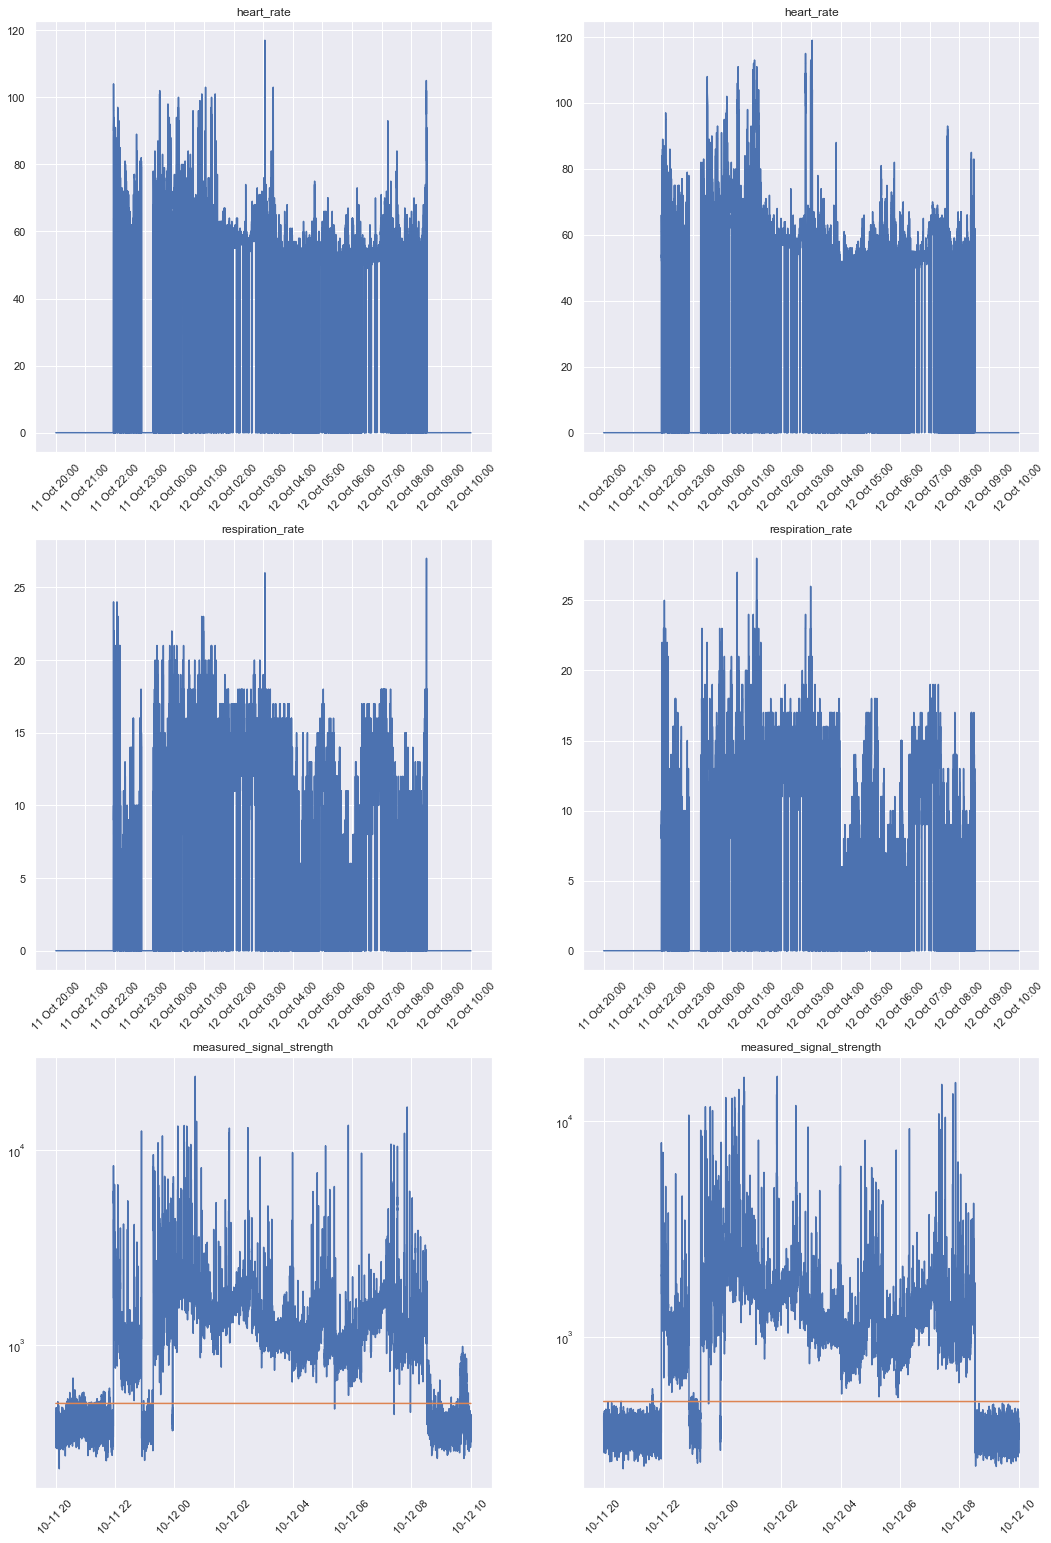

In [68]:
def compare_features(features, save=False):
    nbr_features = len(features)
    fig, axs = plt.subplots(nbr_features, 2, figsize=(18,9 * nbr_features))

    locator = mdates.HourLocator()
    formatter = mdates.DateFormatter('%d %b %H:%M')
    
    for i in (0, 1):
        for ax in axs[i]:
            ax.xaxis.set_major_formatter(formatter)
            ax.xaxis.set_major_locator(locator)
    
    x1 = df1['timestamp']
    x2 = df2['timestamp']
    xs = (x1, x2)
    dfs = (df1, df2)
    feature_dict = {}
    for i in (0, 1):
        feature_dict[i] = {}
        for feature in features:
            feature_dict[i][feature] = dfs[i][feature]
    
    for i in (0, 1):
        for j, (name, values) in enumerate(feature_dict[i].items()):
            axs[j][i].plot(xs[i], values)
            axs[j][i].xaxis.set_tick_params(rotation=45)
            axs[j][i].set_title(f'{name} {i+1}')
            if name == 'measured_signal_strength':
                axs[j][i].plot(xs[i], [THRESHOLD for _ in xs[i]])
                axs[j][i].set_yscale('log')
    if save:
        fig.savefig('sensor_data_example_21.09.png')

    plt.show()

compare_features(['heart_rate', 'respiration_rate', 'measured_signal_strength'])

## Replace "missing" values

The sensor sometimes is not able to detect a signal although the person is in bed. In such case it will send 0-values. This explains why in the graphs above (heart_rate (HR) and respiration_rate (RR)) the signal jups quite often to zero.

However even if no heart rate or respiration rate can be detected, the measured signal strength (MSS) will produce a high value.
Observations have shown, that if the MSS is below a given threshold (e.g 500) the bed is actually not occupied. In this case the zero-values sent by the sensor are legit. If the MSS is above the threshold but HR and RR are zero, this must be considered as **missing value**.

The forward fill will produce a slight look ahead bias. But due to the fine granularity of the data and the downsampling to come, this is negligible.

We replace these values using a custom forward fill.

In [6]:
LAST_VAL = 0

def custom_ffill(row, col_name):
    global LAST_VAL
    if row['measured_signal_strength'] > THRESHOLD and row[col_name] == 0:
        row[f'{col_name}_ff'] = LAST_VAL
        LAST_VAL = row[f'{col_name}_ff']
    else:
        LAST_VAL = row[col_name]
    return row

attribute = 'heart_rate'
df1[f'{attribute}_ff'] = df1[attribute]
df1 = df1.apply(lambda row: custom_ffill(row, attribute), axis='columns')

LAST_VAL = 0  # Reset LAST_VAL
attribute = 'respiration_rate'
df1[f'{attribute}_ff'] = df1[attribute]
df1 = df1.apply(lambda row: custom_ffill(row, attribute), axis='columns')

LAST_VAL = 0  # Reset LAST_VAL
attribute = 'heart_rate'
df2[f'{attribute}_ff'] = df2[attribute]
df2 = df2.apply(lambda row: custom_ffill(row, attribute), axis='columns')


LAST_VAL = 0  # Reset LAST_VAL
attribute = 'respiration_rate'
df2[f'{attribute}_ff'] = df2[attribute]
df2 = df2.apply(lambda row: custom_ffill(row, attribute), axis='columns')


/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


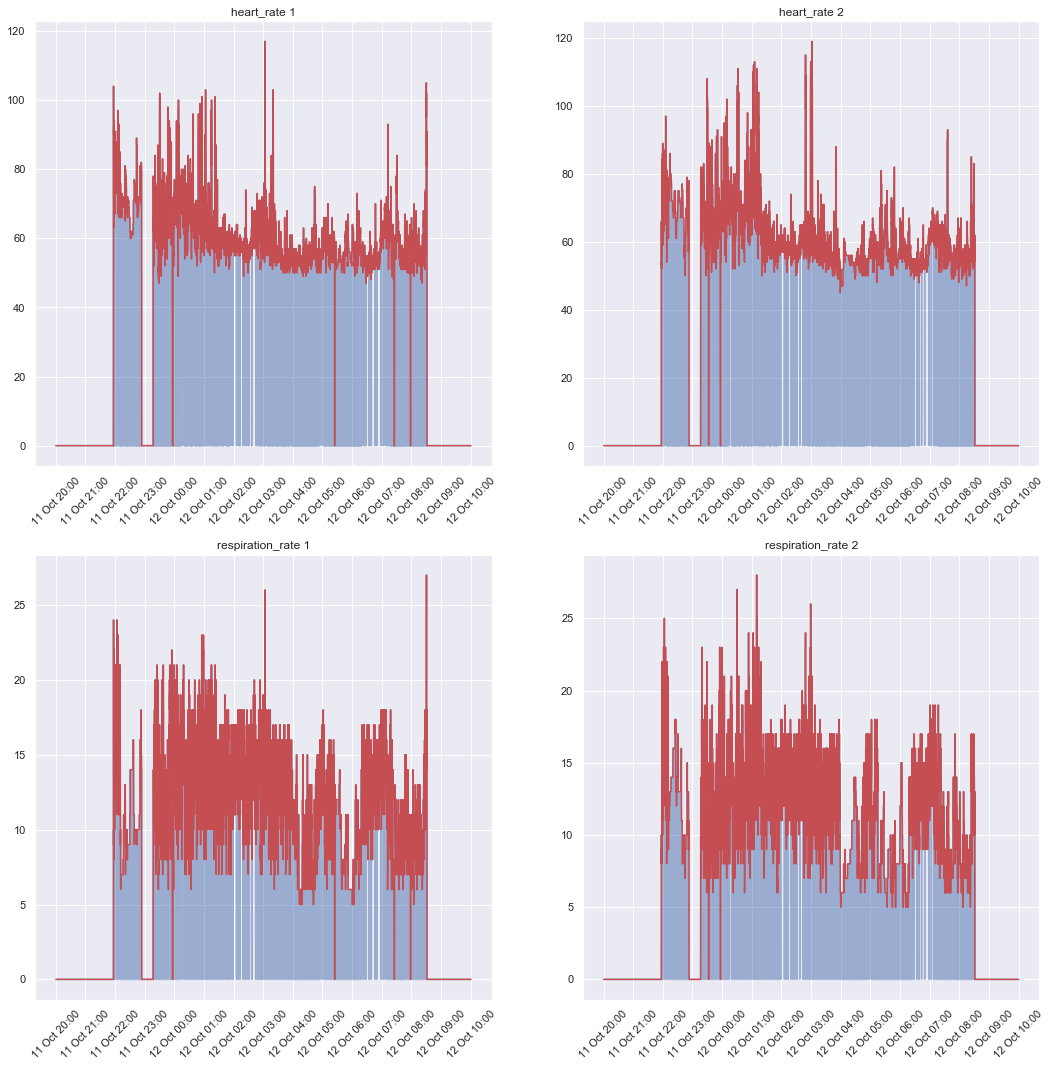

In [7]:
def display_ff(features, save=False):
    nbr_features = len(features)
    fig, axs = plt.subplots(nbr_features, 2, figsize=(18,9 * nbr_features))

    locator = mdates.HourLocator()
    formatter = mdates.DateFormatter('%d %b %H:%M')
    
    for i in (0, 1):
        for ax in axs[i]:
            ax.xaxis.set_major_formatter(formatter)
            ax.xaxis.set_major_locator(locator)
    
    x1 = df1['timestamp']
    x2 = df2['timestamp']
    xs = (x1, x2)
    dfs = (df1, df2)
    feature_dict = {}
    for i in (0, 1):
        feature_dict[i] = {}
        for feature in features:
            feature_dict[i][feature] = dfs[i][feature]
    
    for i in (0, 1):
        for j, (name, values) in enumerate(feature_dict[i].items()):
            axs[j][i].plot(xs[i], values, alpha=.5)
            axs[j][i].plot(xs[i], dfs[i][f'{name}_ff'], 'r-')
            axs[j][i].xaxis.set_tick_params(rotation=45)
            axs[j][i].set_title(f'{name} {i+1}')
        
    if save:
        fig.savefig('todo.png')

    plt.show()

display_ff(['heart_rate', 'respiration_rate'])

As we can clearly see above, most of the unwanted zero-values are now gone. Around 23:00 the proband was indeed not in the bed as the remaining (legit) zero-values illustrate.

Before we continue with the down sampling have a look at the vizualized similarity of the reference time series.
A rolling window approach with a window size of 600 (^= 10min) is used to do so.

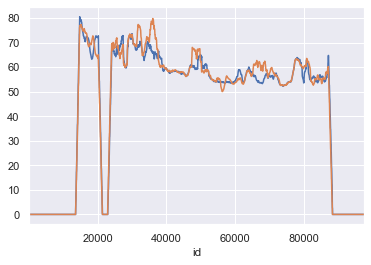

In [8]:
df1['heart_rate_ff'].rolling(600, min_periods=1).mean().plot()
df2['heart_rate_ff'].rolling(600, min_periods=1).mean().plot()

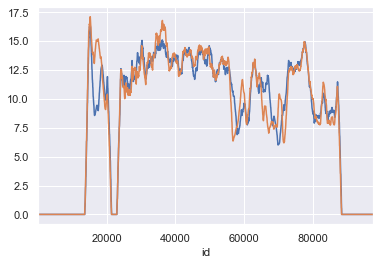

In [9]:
df1['respiration_rate_ff'].rolling(600, min_periods=1).mean().plot()
df2['respiration_rate_ff'].rolling(600, min_periods=1).mean().plot()

## Downsampling

The downsampling shall produce different granularities using resample approaches.

* 1 Hour
* 30 Minutes
* 5 Minutes
* 1 Minute

For each granularity a reference-csv file will be created containing the corresponding down-sampled values for df1 and df2

In [31]:
down_sample_df1 = df1.set_index(df1['timestamp'], inplace=False)
down_sample_df2 = df2.set_index(df1['timestamp'], inplace=False)

### 1 Hour granularity

In [32]:
df1_1hour = down_sample_df1[['heart_rate_ff', 'respiration_rate_ff']].resample('60Min').mean()
df1_1hour.columns = ['heart_rate_1', 'respiration_rate_1']

df2_1hour = down_sample_df2[['heart_rate_ff', 'respiration_rate_ff']].resample('60Min').mean()
df2_1hour.columns = ['heart_rate_2', 'respiration_rate_2']


In [33]:
df_1hour = pd.merge(df1_1hour, df2_1hour, how='left', on=['timestamp'])

In [34]:
df_1hour.head()

,heart_rate_1,respiration_rate_1,heart_rate_2,respiration_rate_2
timestamp,,,,
2020-10-11 20:00:00+00:00,0.000000,0.000000,0.000000,0.000000
2020-10-11 21:00:00+00:00,5.442720,0.904063,4.706264,0.884029
2020-10-11 22:00:00+00:00,64.185748,10.440713,63.785923,11.914136
2020-10-11 23:00:00+00:00,46.728108,8.230261,47.019811,8.102211
2020-10-12 00:00:00+00:00,68.880528,13.662550,71.042791,13.359276


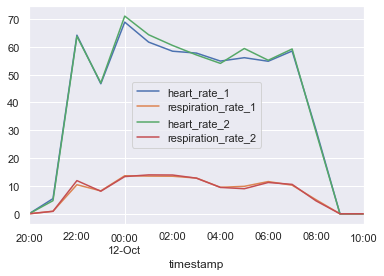

In [35]:
df_1hour.plot()

In [36]:
df_1hour.to_csv(REF_PATH_CLEAN + 'ref_1hour.csv')

### 30 minutes granularity

In [37]:
df1_30min = down_sample_df1[['heart_rate_ff', 'respiration_rate_ff']].resample('30Min').mean()
df1_30min.columns = ['heart_rate_1', 'respiration_rate_1']

df2_30min = down_sample_df2[['heart_rate_ff', 'respiration_rate_ff']].resample('30Min').mean()
df2_30min.columns = ['heart_rate_2', 'respiration_rate_2']

In [38]:
df_30min = pd.merge(df1_30min, df2_30min, how='left', on=['timestamp'])

In [39]:
df_30min.head()

,heart_rate_1,respiration_rate_1,heart_rate_2,respiration_rate_2
timestamp,,,,
2020-10-11 20:00:00+00:00,0.000000,0.000000,0.000000,0.000000
2020-10-11 20:30:00+00:00,0.000000,0.000000,0.000000,0.000000
2020-10-11 21:00:00+00:00,0.000000,0.000000,0.000000,0.000000
2020-10-11 21:30:00+00:00,10.704218,1.778024,9.255827,1.738624
2020-10-11 22:00:00+00:00,73.505351,11.307967,73.372771,15.032699


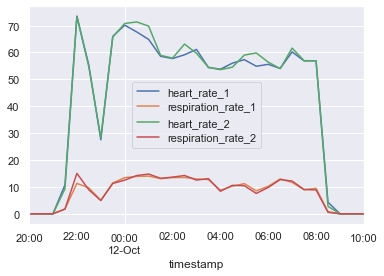

In [40]:
df_30min.plot()

In [41]:
df_30min.to_csv(REF_PATH_CLEAN + 'ref_30min.csv')

### 5 minutes granularity


In [42]:
df1_5min = down_sample_df1[['heart_rate_ff', 'respiration_rate_ff']].resample('5Min').mean()
df1_5min.columns = ['heart_rate_1', 'respiration_rate_1']

df2_5min = down_sample_df2[['heart_rate_ff', 'respiration_rate_ff']].resample('5Min').mean()
df2_5min.columns = ['heart_rate_2', 'respiration_rate_2']

In [43]:
df_5min = pd.merge(df1_5min, df2_5min, how='left', on=['timestamp'])

In [44]:
df_5min.head()

,heart_rate_1,respiration_rate_1,heart_rate_2,respiration_rate_2
timestamp,,,,
2020-10-11 20:00:00+00:00,0.0,0.0,0.0,0.0
2020-10-11 20:05:00+00:00,0.0,0.0,0.0,0.0
2020-10-11 20:10:00+00:00,0.0,0.0,0.0,0.0
2020-10-11 20:15:00+00:00,0.0,0.0,0.0,0.0
2020-10-11 20:20:00+00:00,0.0,0.0,0.0,0.0


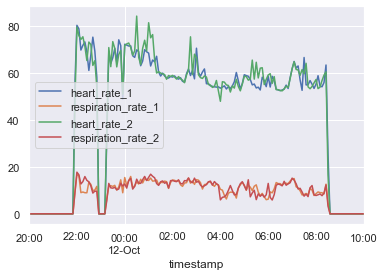

In [45]:
df_5min.plot()

In [46]:
df_5min.to_csv(REF_PATH_CLEAN + 'ref_5min.csv')

### 1 minutes granularity


In [47]:
df1_1min = down_sample_df1[['heart_rate_ff', 'respiration_rate_ff']].resample('1Min').mean()
df1_1min.columns = ['heart_rate_1', 'respiration_rate_1']

df2_1min = down_sample_df2[['heart_rate_ff', 'respiration_rate_ff']].resample('1Min').mean()
df2_1min.columns = ['heart_rate_2', 'respiration_rate_2']

In [48]:
df_1min = pd.merge(df1_1min, df2_1min, how='left', on=['timestamp'])

In [49]:
df_1min.head()

,heart_rate_1,respiration_rate_1,heart_rate_2,respiration_rate_2
timestamp,,,,
2020-10-11 20:00:00+00:00,0.0,0.0,0.0,0.0
2020-10-11 20:01:00+00:00,0.0,0.0,0.0,0.0
2020-10-11 20:02:00+00:00,0.0,0.0,0.0,0.0
2020-10-11 20:03:00+00:00,0.0,0.0,0.0,0.0
2020-10-11 20:04:00+00:00,0.0,0.0,0.0,0.0


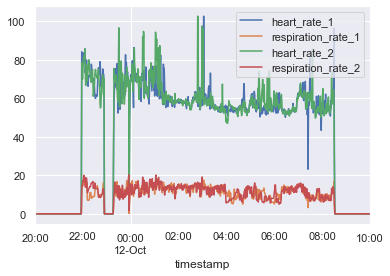

In [50]:
df_1min.plot()

In [51]:
df_1min.to_csv(REF_PATH_CLEAN + 'ref_1min.csv')